In [3]:
import pandas as pd
import numpy as np
import scorecardpy as sc
from Function.bin import *
from Function.model import *
from Function.clean import *
from Function.parameters import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf
from time import time
import matplotlib.pyplot as plt
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
warnings.filterwarnings('ignore')

In [2]:
dat=pd.read_csv('out/AllData.csv')

## 1.初始化

数据探索

In [5]:
#初始化数据,转换特征为合适的数据结构
dat1=Initialization(dat)

In [6]:
#产生数据质量报告-连续变量
NumVar=ReportNum(dat)
NumVar

,VarName,count,mean,std,min,20%,40%,50%,60%,80%,max,MissingRate
0,BillUseRate_CV_AVG_ACC_L3M,40142.0,0.548068,0.303644,0.000000,0.295959,0.426949,0.495386,0.569881,0.786982,1.732051,0.00000
1,BillUseRate_AVG_L3M,40142.0,0.671559,0.377008,0.000000,0.392024,0.522782,0.590525,0.664395,0.891200,4.409511,0.00000
2,Spend_CV_Min_L6M,40142.0,0.597456,0.204075,0.042964,0.426466,0.530330,0.577256,0.626141,0.749895,2.289858,0.00000
3,Spend_CV_Avg_L12M,40142.0,0.617473,0.138755,0.192830,0.500203,0.573731,0.607347,0.643008,0.729214,1.376820,0.00000
4,NumAcc_HighBillUseRate_L3M,40142.0,0.365303,0.531820,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
150,Pay_Ratio_MAX_AMT_ACC_L12M,40142.0,0.565548,0.158161,0.000000,0.430037,0.526944,0.562800,0.610169,0.702883,1.000041,0.00000
151,Delq1_Percent_L12M,40142.0,0.395440,0.147930,0.000000,0.250000,0.333333,0.416667,0.416667,0.500000,1.000000,0.00000
152,BillUseRate_Trend_AVG_ACC_L6M,40142.0,1.025846,0.582840,0.000000,0.516299,0.825445,0.973065,1.133872,1.525312,4.622852,0.00000
153,SpendUseRate_Trend_AVG_ACC_L3M,40089.0,1.096241,0.657725,0.000000,0.529809,0.988188,1.144419,1.286929,1.610064,3.000000,0.00132


In [7]:
#产生数据质量报告-分类变量
#CharVar=ReportChar(dat)

数据清洗

In [8]:
### 重复值
dat2=dat1.drop_duplicates()

### 缺失值--不处理

### 极端值--视为合理存在,不处理

### 错误值

## 2.变量粗筛

In [9]:
X_train, X_test, y_train, y_test=train_test_split(dat2.drop('Target',1),dat2.Target,test_size=0.33, 
                                                    random_state=1223,stratify=dat2.Target)

剔除非常不重要的变量

In [10]:
##Sklearn中RF不支持缺失值,填补为-9999,仅适用于随机森林
def VarFliter_Step_1(X_train,y_train):
    
    X_train_rf=NaNFill(X_train.drop(FacCol,1))
    
    rf=RandomForestClassifier(
        n_estimators=500,#500
        max_depth=6, #每棵树最多2**max_depth个叶节点,为展示省时间,设定6
        min_samples_split=0.1, 
        min_samples_leaf=0.05, #平均比例为1/(2**max_depth)
        bootstrap=True,
        oob_score=True,
        max_features=None,
        random_state=123,
        n_jobs=-1 
    ) 
    
    now=time()
    rf_res=rf.fit(X_train_rf,y_train) #2.9 GHz Intel Core i5为7分钟左右
    pass_t=time()-now
    print(pass_t)
    
    VarFKeep_Step_1=X_train_rf.columns[rf_res.feature_importances_>0].tolist()
    
    return(VarFKeep_Step_1)
    
VarSelect={}
VarSelect['Step_1']=VarFliter_Step_1(X_train,y_train)

69.09558701515198


## 3.变量细筛

细分箱

In [11]:
#细分箱
finebinBL=FreqBinbreaklist(X_train) #产生细分箱分段

finebin=sc.woebin(X_train[VarSelect['Step_1']+FacCol].join(y_train),
                  y='Target',
                  breaks_list=finebinBL)

[INFO] creating woe binning ...


In [12]:
def VarFliter_Step_2(finebin,ivlimit=0.02,uniquelimitNum=0.6,uniquelimitChar=0.8):
    
    #对连续变量,若细分箱iv低于0.02的特征舍弃,唯一值占比过高(大于60%)的舍弃
    #对分类变量,若细分箱iv低于0.02的特征舍弃,唯一值占比过高(大于80%)的舍弃   
    
    global FacCol
    
    finebindf=pd.concat(finebin.values())
    
    Numfinbindf=finebindf[~finebindf.variable.isin(FacCol)]
    Facfinbindf=finebindf[finebindf.variable.isin(FacCol)]
    
    VarFKeep_Step_2=Numfinbindf.groupby('variable')[['count_distr']].max().join(
        Numfinbindf.groupby('variable').bin_iv.sum().rename('iv')
    ).query("count_distr<="+str(uniquelimitNum)+" & iv>="+str(ivlimit)).index.tolist()+Facfinbindf.groupby('variable')[['count_distr']].max().join(
        Facfinbindf.groupby('variable').bin_iv.sum().rename('iv')
    ).query("count_distr<="+str(uniquelimitChar)+" & iv>="+str(ivlimit)).index.tolist()
    
    finebin_adj=delkey_finebin(finebin=finebin.copy(),keep=VarFKeep_Step_2)
    
    return(finebin_adj,VarFKeep_Step_2)

In [13]:
finebin_adj,VarSelect['Step_2']=VarFliter_Step_2(finebin)

交互式分箱

In [14]:
## 粗分箱与交互式分箱,剔除可解释性差,非单调变化,异常特征,相似特征等
# plt.rcParams["figure.figsize"] = (15,6)
# plt.rcParams['font.sans-serif']=['SimHei']

# coarse_breaklist=sc.woebin_adj(
#     dt=X_train[VarSelect['Step_2']+FacCol].join(y_train),y='Target',
#     count_distr_limit=0.05,
#     bins=finebin_adj,method='chimerge') 
#节省时间,略过交互式分箱,实践时应对各个特征进行详细分析,根据业务常识调整bin

最终分箱与WOE转换

In [16]:
break_list=breaks_list={
'Balance_CV_Avg_L3M': [0.5,0.6000000000000001,0.8], 
'Balance_CV_Max_L3M': [0.5,0.6000000000000001,0.8], 
'Balance_CV_Min_L3M': [0.5,0.6000000000000001,0.8], 
'BillUseRate_AVG_ACC_L12M': [0.4,0.5,0.6,0.7000000000000001,0.8], 
'BillUseRate_AVG_ACC_L3M': [0.4,0.6000000000000001,0.7000000000000001,0.9,1.2000000000000002], 
'BillUseRate_AVG_ACC_L6M': [0.4,0.5,0.6000000000000001,0.8,1.1], 
'BillUseRate_AVG_L12M': [0.4,0.5,0.6,0.7000000000000001,0.8], 
'BillUseRate_AVG_L3M': [0.4,0.6000000000000001,0.7000000000000001,0.9,1.2000000000000002], 
'BillUseRate_AVG_L6M': [0.4,0.5,0.6000000000000001,0.8,1.1], 
'BillUseRate_CV_AVG_ACC_L3M': [0.5,0.6000000000000001,0.8], 
'BillUseRate_CV_MAX_ACC_L12M': [0.5,0.6,0.8], 
'BillUseRate_CV_MAX_ACC_L3M': [0.5,0.8], 
'BillUseRate_CV_MIN_ACC_L3M': [0.4,0.5,0.6000000000000001,0.8], 
'BillUseRate_CV_MIN_ACC_L6M': [0.5,0.6000000000000001,0.8], 
'BillUseRate_MAX_ACC_L12M': [0.4,0.5,0.6,0.7000000000000001,0.8], 
'BillUseRate_MAX_ACC_L3M': [0.4,0.7000000000000001,0.9,1.2000000000000002,1.5], 
'BillUseRate_MAX_ACC_L6M': [0.5,0.6000000000000001,0.8,0.9,1.0], 
'BillUseRate_MAX_L12M': [0.9999999999999999,1.1999999999999997,1.4999999999999998,1.5999999999999999,2.0999999999999996], 
'BillUseRate_MAX_L3M': [0.8,1.0,1.2000000000000002,1.5,2.1], 
'BillUseRate_MAX_L6M': [0.8000000000000003,1.0000000000000002,1.2000000000000004,1.5000000000000004,2.1000000000000005], 
'BillUseRate_MIN_ACC_L12M': [0.5,0.6,0.7000000000000001,0.8], 
'BillUseRate_MIN_ACC_L3M': [0.5,0.7000000000000001,0.9,1.2000000000000002], 
'BillUseRate_MIN_ACC_L6M': [0.5,0.6000000000000001,0.8,0.9], 
'BillUseRate_MIN_L3M': [0.1,0.4,0.5,0.6000000000000001,0.8], 
'BillUseRate_MIN_L6M': [0.1,0.4], 
'BillUseRate_Trend_AVG_ACC_L12M': [0.8,1.3,1.6,1.9000000000000001,2.3000000000000003], 
'BillUseRate_Trend_AVG_ACC_L3M': [0.9,1.0,1.1,1.2000000000000002,1.5], 
'BillUseRate_Trend_AVG_ACC_L6M': [0.2,0.8,1.0,1.3,1.5], 
'BillUseRate_Trend_MAX_ACC_L12M': [0.8,1.3,1.6,2.0,2.3000000000000003], 
'BillUseRate_Trend_MAX_ACC_L3M': [1.0,1.1,1.2000000000000002,1.4000000000000001], 
'BillUseRate_Trend_MAX_ACC_L6M': [0.5,1.0,1.3,1.5,1.7000000000000002], 
'CreditLimit_MIN': [50000.0,80000.0,240000.0], 
'CreditLimit_SUM': [60000.0,120000.0,160000.0,220000.0,300000.0], 
'Delq1_Count_L12M': [4.0,5.0,6.0,7.0,11.0], 
'Delq1_Count_L3M': [1.0,2.0,3.0], 
'Delq1_Percent_L12M': [0.2,0.30000000000000004,0.4,0.5,0.6000000000000001], 
'Delq2_Count_L12M': [1.0,2.0,3.0,4.0], 
'Delq2_Percent_L12M': [0.1,0.2], 
'Delq_Status_L3M': [1.0,2.0], 
'Pay_Ratio_AVG_AMT_ACC_L12M': [0.4,0.5,0.6000000000000001,0.7000000000000001,0.8], 
'Pay_Ratio_AVG_AMT_ACC_L3M': [0.2,0.4,0.5,0.6000000000000001,0.8], 
'Pay_Ratio_AVG_AMT_ACC_L6M': [0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001], 
'Pay_Ratio_AVG_AMT_L12M': [0.4,0.5,0.6000000000000001,0.7000000000000001,0.8], 
'Pay_Ratio_AVG_AMT_L3M': [0.2,0.4,0.5,0.6000000000000001,0.8], 
'Pay_Ratio_AVG_AMT_L6M': [0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001], 
'Pay_Ratio_Count_AVG_ACC_L12M': [0.4,0.5,0.6000000000000001,0.7000000000000001,0.8], 
'Pay_Ratio_Count_L12M': [0.4,0.5,0.6000000000000001,0.7000000000000001,0.8], 
'Pay_Ratio_Count_L6M': [0.5,0.6000000000000001,0.8], 
'Pay_Ratio_Count_MAX_ACC_L6M': [0.5,0.6666666666666666,0.8333333333333334], 
'Pay_Ratio_Count_MIN_ACC_L12M': [0.4,0.5,0.6000000000000001,0.7000000000000001,0.8], 
'Pay_Ratio_MAX_AMT_ACC_L12M': [0.4,0.5,0.6000000000000001,0.7000000000000001], 
'Pay_Ratio_MAX_AMT_ACC_L3M': [0.1,0.4,0.9,1.0], 
'Pay_Ratio_MAX_AMT_ACC_L6M': [0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001], 
'Pay_Ratio_MAX_AMT_L12M': [1.0,1.00001], 
'Pay_Ratio_MAX_AMT_L3M': [0.6000000000000001,0.9,1.0], 
'Pay_Ratio_MIN_AMT_ACC_L12M': [0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001], 
'Pay_Ratio_MIN_AMT_ACC_L3M': [0.1,0.30000000000000004,0.4,0.6000000000000001,0.7000000000000001], 
'Pay_Ratio_MIN_AMT_ACC_L6M': [0.2,0.30000000000000004,0.4,0.5,0.7000000000000001], 
'SpendUseRate_AVG_ACC_L3M': [0.2,0.30000000000000004,0.4,0.5], 
'SpendUseRate_AVG_ACC_L6M': [0.30000000000000004,0.4], 
'SpendUseRate_AVG_L3M': [0.2,0.30000000000000004,0.4,0.5], 
'SpendUseRate_AVG_L6M': [0.30000000000000004,0.4], 
'SpendUseRate_CV_AVG_ACC_L3M': [0.4,0.7000000000000001,1.0], 
'SpendUseRate_CV_AVG_ACC_L6M': [0.5,0.8], 
'SpendUseRate_MAX_ACC_L12M': [0.30000000000000004,0.4], 
'SpendUseRate_MAX_ACC_L3M': [0.2,0.30000000000000004,0.4,0.5,0.6000000000000001], 
'SpendUseRate_MAX_ACC_L6M': [0.30000000000000004,0.4,0.5], 
'SpendUseRate_MAX_L12M': [0.6,0.7,0.7999999999999999,0.8999999999999999,0.9999999999999999], 
'SpendUseRate_MAX_L3M': [0.4,0.5,0.6000000000000001,0.7000000000000001,0.9], 
'SpendUseRate_MAX_L6M': [0.5,0.6,0.7000000000000001,0.8,0.9], 
'SpendUseRate_MIN_ACC_L3M': [0.30000000000000004,0.4,0.5], 
'SpendUseRate_Trend_AVG_ACC_L12M': [0.2,0.6000000000000001,0.9,1.3,1.8], 
'SpendUseRate_Trend_AVG_ACC_L3M': [0.2,0.6000000000000001,0.8,1.1,1.8], 
'SpendUseRate_Trend_AVG_ACC_L6M': [0.30000000000000004,0.7000000000000001,1.2000000000000002], 
'SpendUseRate_Trend_MAX_ACC_L12M': [0.6000000000000001,1.0,1.2000000000000002,1.6,2.3000000000000003], 
'SpendUseRate_Trend_MAX_ACC_L3M': [0.2,0.8,1.1,1.2000000000000002], 
'SpendUseRate_Trend_MAX_ACC_L6M': [0.30000000000000004,0.7000000000000001,1.1,1.4000000000000001,1.9000000000000001], 
'Spend_CV_Avg_L3M': [0.5,0.6000000000000001,0.8], 
'Spend_CV_Max_L3M': [0.5,0.6000000000000001,0.8], 
'Spend_CV_Min_L3M': [0.5,0.6000000000000001,0.8]}

In [17]:
finalbin=sc.woebin(dt=X_train[VarSelect['Step_2']].join(y_train),
                   y='Target',
                   method='chimerge',
                   bin_num_limit=6,
                   count_distr_limit=0.05,
                   breaks_list=break_list)
                   #save_breaks_list='break_list')
train_woe=sc.woebin_ply(X_train[finalbin.keys()],finalbin)
test_woe=sc.woebin_ply(X_test[finalbin.keys()],finalbin)

[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


剔除变量组中相关系数较高但IV较低的变量

In [18]:
pairs_all,var_keep=corr_group(finalbin,train_woe,y_train,keep_num=1)
VarSelect['Step_3']=var_keep
VarSelect['Step_3']

['BillUseRate_CV_MIN_ACC_L3M_woe',
 'BillUseRate_MAX_ACC_L3M_woe',
 'Delq2_Count_L12M_woe',
 'SpendUseRate_CV_AVG_ACC_L3M_woe',
 'BillUseRate_MIN_ACC_L3M_woe',
 'Pay_Ratio_MIN_AMT_ACC_L6M_woe',
 'SpendUseRate_Trend_MAX_ACC_L12M_woe',
 'BillUseRate_MIN_L3M_woe',
 'Pay_Ratio_Count_L6M_woe',
 'SpendUseRate_MAX_ACC_L3M_woe',
 'SpendUseRate_MAX_L3M_woe',
 'Delq_Status_L3M_woe',
 'BillUseRate_AVG_L3M_woe',
 'SpendUseRate_MAX_ACC_L6M_woe',
 'BillUseRate_Trend_MAX_ACC_L12M_woe',
 'Pay_Ratio_MIN_AMT_ACC_L3M_woe',
 'BillUseRate_CV_MAX_ACC_L12M_woe',
 'Pay_Ratio_MAX_AMT_L12M_woe',
 'CreditLimit_MIN_woe',
 'CreditLimit_SUM_woe']

## 4.Logistic回归建模

In [19]:
VarSelect['Step_4']=['Delq_Status_L3M_woe','SpendUseRate_Trend_MAX_ACC_L12M_woe',
                     'Delq2_Count_L12M_woe','SpendUseRate_MAX_ACC_L3M_woe',
                     'BillUseRate_MIN_L3M_woe','Pay_Ratio_MIN_AMT_ACC_L3M_woe']

In [20]:
logit_model=stepwise(train_woe[VarSelect['Step_4']].join(y_train),'Target',criterion='bic',p_value_enter=0.05)

Optimization terminated successfully.
         Current function value: 0.324452
         Iterations 7

stepwise starting:

Optimization terminated successfully.
         Current function value: 0.324452
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374021
         Iterations 6
Adding Delq_Status_L3M_woe, bic = 17472.657
Optimization terminated successfully.
         Current function value: 0.324452
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.312996
         Iterations 7
Optimization term

In [21]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                26895
Model:                          Logit   Df Residuals:                    26888
Method:                           MLE   Df Model:                            6
Date:                Tue, 30 Jun 2020   Pseudo R-squ.:                  0.3148
Time:                        18:11:51   Log-Likelihood:                -8139.5
converged:                       True   LL-Null:                       -11879.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -1.6533      0.022    -76.642      0.000      -1.696      -1.611
Delq_Status_L3M_woe                     0.7682      0.018     41.574      0.000       0.732       0.804
SpendUseRate_Trend_MAX_ACC_L12M_woe     0.9001      0.063     14.283      0.000       0.777       1.024
Pay_Ratio_MIN_AMT_ACC_L3M_woe           0.3450      0.024     14.471      0.000       0.298       0.392
Delq2_Count_L12M_woe                    0.2714      0.026     10.247      0.000       0.220       0.323
SpendUseRate_MAX_ACC_L3M_woe            0.6130      0.064      9.530      0.000       0.487       0.739
BillUseRate_MIN_L3M_woe                 0.2358      0.042      5.622      0.000       0.154       0.318
=======================================================================================================
"""

In [22]:
Vif(logit_model,train_woe)

,VIF Factor,features
0,2.085819,Delq_Status_L3M_woe
1,1.622775,SpendUseRate_Trend_MAX_ACC_L12M_woe
2,1.780248,Pay_Ratio_MIN_AMT_ACC_L3M_woe
3,1.491987,Delq2_Count_L12M_woe
4,1.616322,SpendUseRate_MAX_ACC_L3M_woe
5,1.229055,BillUseRate_MIN_L3M_woe


## 5.模型评估

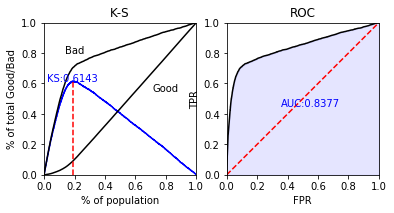

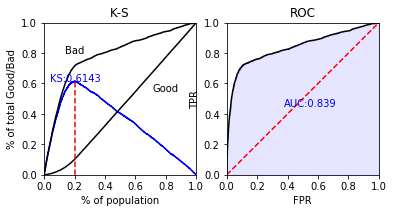

{'KS': 0.6143,
 'AUC': 0.839,
 'Gini': 0.678,
 'pic': <Figure size 432x288 with 2 Axes>}

In [23]:
pred_prob_train=logit_model.predict(train_woe)
pred_prob_test=logit_model.predict(test_woe)
sc.perf_eva(y_train,pred_prob_train)
sc.perf_eva(y_test,pred_prob_test)

## 6.制作评分卡

In [24]:
logit_model.coef_=np.array([logit_model.params.ravel()])
logit_model.intercept_=[logit_model.params[0]]

In [25]:
card=sc.scorecard(bins=finalbin,model=logit_model,xcolumns=logit_model.params.index.ravel(),
                  points0=600,odds0=1/19,basepoints_eq0=False)

In [26]:
pd.concat(card)

variable  \
basepoints                      0                         basepoints   
Delq_Status_L3M                 305                  Delq_Status_L3M   
                                306                  Delq_Status_L3M   
                                307                  Delq_Status_L3M   
SpendUseRate_Trend_MAX_ACC_L12M 77   SpendUseRate_Trend_MAX_ACC_L12M   
                                78   SpendUseRate_Trend_MAX_ACC_L12M   
                                79   SpendUseRate_Trend_MAX_ACC_L12M   
                                80   SpendUseRate_Trend_MAX_ACC_L12M   
                                81   SpendUseRate_Trend_MAX_ACC_L12M   
                                82   SpendUseRate_Trend_MAX_ACC_L12M   
Pay_Ratio_MIN_AMT_ACC_L3M       259        Pay_Ratio_MIN_AMT_ACC_L3M   
                                260        Pay_Ratio_MIN_AMT_ACC_L3M   
                                261        Pay_Ratio_MIN_AMT_ACC_L3M   
                                262        Pay_Ratio_MIN_AMT_ACC_L3M   
                                263        Pay_Ratio_MIN_AMT_ACC_L3M   
                                264        Pay_Ratio_MIN_AMT_ACC_L3M   
                                265        Pay_Ratio_MIN_AMT_ACC_L3M   
Delq2_Count_L12M                214                 Delq2_Count_L12M   
                                215                 Delq2_Count_L12M   
                                216                 Delq2_Count_L12M   
                                217                 Delq2_Count_L12M   
                                218                 Delq2_Count_L12M   
SpendUseRate_MAX_ACC_L3M        247         SpendUseRate_MAX_ACC_L3M   
                                248         SpendUseRate_MAX_ACC_L3M   
                                249         SpendUseRate_MAX_ACC_L3M   
                                250         SpendUseRate_MAX_ACC_L3M   
                                251         SpendUseRate_MAX_ACC_L3M   
                                252         SpendUseRate_MAX_ACC_L3M   
BillUseRate_MIN_L3M             117              BillUseRate_MIN_L3M   
                                118              BillUseRate_MIN_L3M   
                                119              BillUseRate_MIN_L3M   
                                120              BillUseRate_MIN_L3M   
                                121              BillUseRate_MIN_L3M   
                                122              BillUseRate_MIN_L3M   

                                                                         bin  \
basepoints                      0                                        NaN   
Delq_Status_L3M                 305                               [-inf,1.0)   
                                306                                [1.0,2.0)   
                                307                                [2.0,inf)   
SpendUseRate_Trend_MAX_ACC_L12M 77                 [-inf,0.6000000000000001)   
                                78                  [0.6000000000000001,1.0)   
                                79                  [1.0,1.2000000000000002)   
                                80                  [1.2000000000000002,1.6)   
                                81                  [1.6,2.3000000000000003)   
                                82                  [2.3000000000000003,inf)   
Pay_Ratio_MIN_AMT_ACC_L3M       259                                  missing   
                                260                               [-inf,0.1)   
                                261                [0.1,0.30000000000000004)   
                                262                [0.30000000000000004,0.4)   
                                263                 [0.4,0.6000000000000001)   
                                264  [0.6000000000000001,0.7000000000000001)   
                                265                 [0.7000000000000001,inf)   
Delq2_Count_L12M                214                               [-inf,1.0)   
                   

In [27]:
score_train=sc.scorecard_ply(X_train,card,only_total_score=False)
score_test=sc.scorecard_ply(X_test,card,only_total_score=False)

In [28]:
def ScorePerformance(train_pred,Y_train,bins):
    '''
    ScorePerformance
    '''

    Result=pd.DataFrame(
        {
            'ScoreBin':pd.cut(train_pred,bins,right=True),
            'Y':Y_train
        }
    ).groupby('ScoreBin')['Y'].agg(['count','sum']).rename(columns={'count':'Count','sum':'Bad'})

    ResultDis=Result.assign(
        CountDis=Result.Count/train_pred.size,
        BadRate=Result.Bad/Result.Count,
        GoodDis=(Result.Count-Result.Bad)/sum(Y_train==0),
        BadDis=Result.Bad/sum(Y_train==1),
    )

    ResultDisCum=ResultDis.assign(
        GoodDisCum=ResultDis.GoodDis.cumsum(),
        BadDisCum=ResultDis.BadDis.cumsum(),
        BinIV=(ResultDis.BadDis-ResultDis.GoodDis)*np.log((ResultDis.BadDis+1e-5)/(ResultDis.GoodDis+1e-5))
    )

    ResultDisKS=ResultDisCum.assign(
        IV=ResultDisCum.BinIV.sum(),
        WOE=np.log((ResultDisCum.BadDis+1e-5)/(ResultDisCum.GoodDis+1e-5)),
        KS=(ResultDisCum.GoodDisCum-ResultDisCum.BadDisCum).abs()
    ).reset_index()
    
    ResultDisKS=ResultDisKS.assign(
            ScoreBin=ResultDisKS.ScoreBin.astype('str')
            )

    return(ResultDisKS)

In [29]:
ScorePerformance(score_train.score,y_train,bins=10)

,ScoreBin,Count,Bad,CountDis,BadRate,GoodDis,BadDis,GoodDisCum,BadDisCum,BinIV,IV,WOE,KS
0,"(251.532, 298.8]",259,234,0.009630,0.903475,0.001108,0.053967,0.001108,0.053967,0.204924,2.275899,3.876829,5.285858e-02
1,"(298.8, 345.6]",1287,1051,0.047853,0.816628,0.010461,0.242389,0.011570,0.296356,0.728702,2.275899,3.141933,2.847864e-01
2,"(345.6, 392.4]",2114,1307,0.078602,0.618259,0.035773,0.301430,0.047343,0.597786,0.566142,2.275899,2.131102,5.504435e-01
3,"(392.4, 439.2]",1481,468,0.055066,0.316003,0.044904,0.107934,0.092247,0.705720,0.055267,2.275899,0.876849,6.134726e-01
4,"(439.2, 486.0]",974,112,0.036215,0.114990,0.038211,0.025830,0.130458,0.731550,0.004846,2.275899,-0.391449,6.010919e-01
5,"(486.0, 532.8]",1448,113,0.053839,0.078039,0.059178,0.026061,0.189636,0.757611,0.027153,2.275899,-0.819902,5.679746e-01
6,"(532.8, 579.6]",4891,293,0.181855,0.059906,0.203821,0.067574,0.393457,0.825185,0.150407,2.275899,-1.103923,4.317273e-01
7,"(579.6, 626.4]",6938,385,0.257966,0.055491,0.290483,0.088792,0.683940,0.913976,0.239039,2.275899,-1.185175,2.300361e-01
8,"(626.4, 673.2]",5067,248,0.188399,0.048944,0.213618,0.057196,0.897558,0.971172,0.206099,2.275899,-1.317583,7.361407e-02
9,"(673.2, 720.0]",2436,125,0.090574,0.051314,0.102442,0.028828,1.000000,1.000000,0.093320,2.275899,-1.267691,1.110223e-16


In [30]:
ScorePerformance(score_test.score,y_test,bins=10)

,ScoreBin,Count,Bad,CountDis,BadRate,GoodDis,BadDis,GoodDisCum,BadDisCum,BinIV,IV,WOE,KS
0,"(257.538, 304.2]",157,142,0.011852,0.904459,0.001350,0.066511,0.001350,0.066511,0.253482,2.257737,3.890105,0.065161
1,"(304.2, 350.4]",682,545,0.051483,0.799120,0.012329,0.255269,0.013679,0.321780,0.736010,2.257737,3.029592,0.308101
2,"(350.4, 396.6]",979,584,0.073904,0.596527,0.035547,0.273536,0.049226,0.595316,0.485576,2.257737,2.040329,0.546090
3,"(396.6, 442.8]",759,241,0.057296,0.317523,0.046616,0.112881,0.095842,0.708197,0.058595,2.257737,0.884255,0.612354
4,"(442.8, 489.0]",496,55,0.037442,0.110887,0.039687,0.025761,0.135529,0.733958,0.006016,2.257737,-0.432017,0.598429
5,"(489.0, 535.2]",756,57,0.057070,0.075397,0.062905,0.026698,0.198434,0.760656,0.031023,2.257737,-0.856825,0.562222
6,"(535.2, 581.4]",2437,142,0.183966,0.058268,0.206533,0.066511,0.404968,0.827166,0.158646,2.257737,-1.133000,0.422199
7,"(581.4, 627.6]",3401,200,0.256737,0.058806,0.288067,0.093677,0.693035,0.920843,0.218353,2.257737,-1.123270,0.227809
8,"(627.6, 673.8]",2346,117,0.177097,0.049872,0.200594,0.054801,0.893629,0.975644,0.189158,2.257737,-1.297443,0.082016
9,"(673.8, 720.0]",1234,52,0.093153,0.042139,0.106371,0.024356,1.000000,1.000000,0.120878,2.257737,-1.473844,0.000000
